In [6]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [23]:
# Basic
import os
import datetime
import pandas as pd
import numpy as np

# Local
from library.lib_aws import PostgresRDS

# PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Tensorflow
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (15,5)
mpl.rcParams['axes.grid'] = False
plt.style.use('dark_background')

## Importing the Data

In [9]:
well_name = 'Cook 12-13 6B'

query = """
SELECT 
    "NodeID",
    "Date",
    "Fillage",
    "SPM"
FROM
    xspoc.card
WHERE
    "NodeID" = '{}' AND
    "Date" BETWEEN '2018-03-19' AND '2020-05-26'
""".format(well_name)

with PostgresRDS(db='oasis-dev') as engine:
    data = pd.read_sql(query, engine, parse_dates=['Date'])
    
print("\nData before converting")
data.dropna(inplace=True)  # Nans arent present, but if they are will have to be dropped
display(data.head())
data.pop('NodeID')  # Dropping NodeID
data.set_index('Date', inplace=True)

Connected to oasis-dev DataBase
Connection Closed

Data before converting


,NodeID,Date,Fillage,SPM
0,Cook 12-13 6B,2019-03-19 00:12:48,94.8,3.1
1,Cook 12-13 6B,2019-03-19 00:55:33,44.9,1.4
2,Cook 12-13 6B,2019-03-19 02:52:18,49.4,1.4
3,Cook 12-13 6B,2019-03-19 03:09:29,98.4,3.1
4,Cook 12-13 6B,2019-03-19 04:20:22,52.8,1.4


Resampled Data


,Fillage,SPM
Date,,
2019-03-19,71.97,2.16
2019-03-20,76.12,2.24
2019-03-21,75.13,2.23
2019-03-22,73.34,2.19
2019-03-23,74.76,2.17


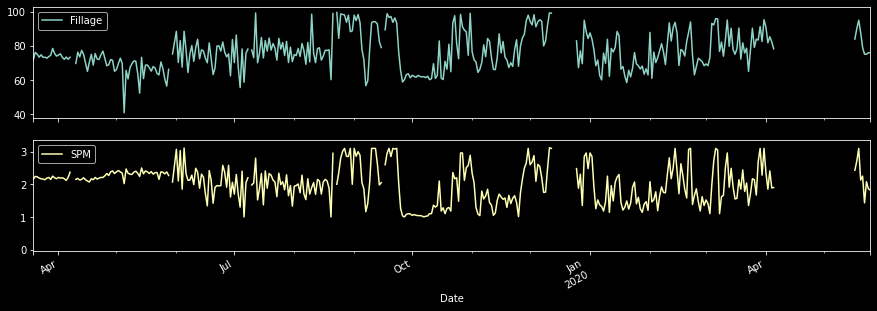

In [15]:
df_r = data.resample('1D').mean().round(2)  # Resampled Data
print('Resampled Data')
display(df_r.head())

# Plotting
_ = df_r.plot(subplots=True)

In [22]:
df_r.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Fillage,378.0,76.856852,10.832246,40.87,69.4725,75.58,83.3525,100.0
SPM,378.0,2.032989,0.567939,0.10,1.6125,2.10,2.3700,3.2


## Splitting the Dataset

In [39]:
column_indices = {name: i for i, name in enumerate(df_r.columns)}

n = len(df_r)
train_df = df_r[0: int(n*0.7)]
val_df = df_r[int(n*0.7): int(n*0.9)]
test_df = df_r[int(n*0.9):]

num_features = df_r.shape[1]

In [40]:
# Normalizing 
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

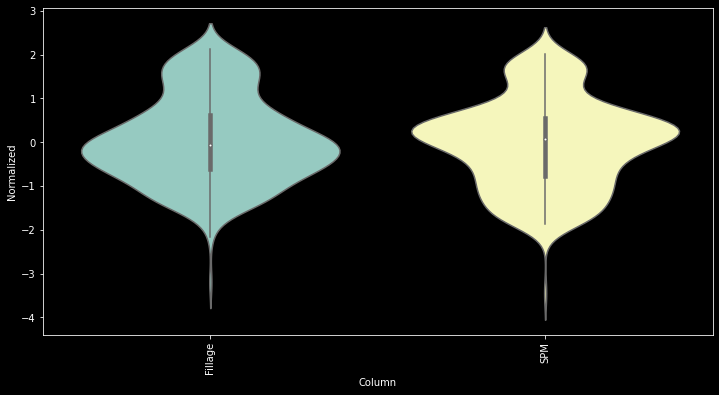

In [44]:
df_std = (df_r - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df_r.keys(), rotation=90)

## Windowing

In [115]:
input_width = 10
label_width = 1
shift = 2
total_window_size = input_width + shift
label_start = total_window_size - label_width

label_col = ['SPM']

input_slice = slice(0, input_width)
label_slice = slice(label_start, None)

input_indices = np.arange(total_window_size)[input_slice]
label_indices = np.arange(total_window_size)[label_slice]

In [116]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[: total_window_size]),
                           np.array(train_df[100:100+total_window_size]),
                           np.array(train_df[200:200+total_window_size])])

In [117]:
inputs = example_window[:,input_slice,:]
labels = example_window[:,label_slice,:]
labels

<tf.Tensor: shape=(3, 1, 2), dtype=float64, numpy=
array([[[-0.07834468,  0.25240082]],

       [[ 0.15174448,  0.25240082]],

       [[-1.37169744, -1.54317187]]])>

In [118]:
labels = tf.stack(
            [labels[:,:, column_indices[name]] for name in label_col], axis=1
        )

inputs.set_shape([None, input_width, None])
labels.set_shape([None, label_width, None])

In [119]:
column_indices

{'Fillage': 0, 'SPM': 1}

In [134]:
label_col_index

1

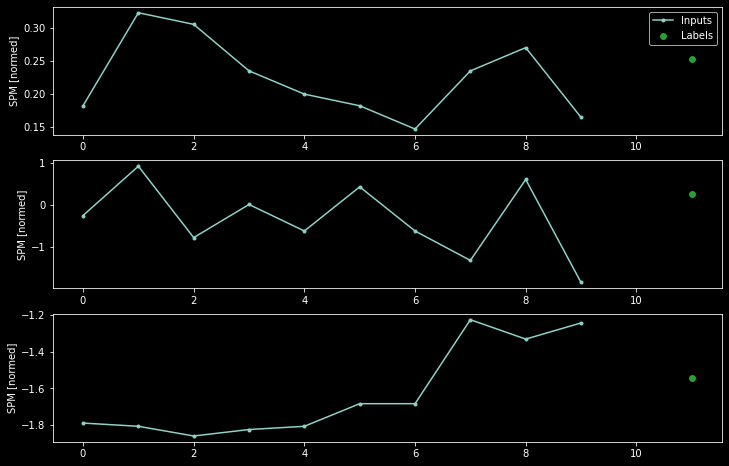

In [137]:
plot_col = 'SPM'
max_subplots=3

plt.figure(figsize=(12, 8))
plot_col_index = column_indices[plot_col]
max_n = min(max_subplots, len(inputs))

for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.',
            zorder=-10)
    
    label_col_index = 0
    
    plt.scatter(label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels',
               c='#2ca02c', s=64)
    
    if n == 0:
        plt.legend()

## Make a Dataset

In [142]:
dd = np.array(df_r, dtype=np.float32)
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=dd,
    targets=None,
    sequence_length = total_window_size,
    sequence_stride=1,
    shuffle=True,
    batch_size=32
)

AttributeError: module 'tensorflow.keras.preprocessing' has no attribute 'timeseries_dataset_from_array'